#### Import packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import inchi
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.ML.Descriptors import MoleculeDescriptors

from pprint import pprint

#### Read data

In [2]:
df = pd.read_csv('data/activity_classes_ChEMBL24.dat', sep='\t')

##### Use data associated with the Histamine H3 receptor

In [3]:
H3 = df[df.TargetName.eq('Histamine H3 receptor')]

In [4]:
H3.head(1)

,TargetID,TargetName,SMILES,AnalogSeriesID,pKi
1558,CHEMBL264,Histamine H3 receptor,C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,23663,7.96


In [5]:
H3.shape

(961, 5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021245E21C88>]],
      dtype=object)

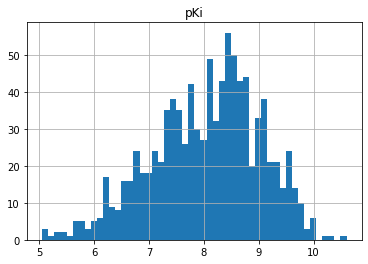

In [6]:
H3.hist('pKi', bins = 50)

#### Build a molecule record from smiles strings

In [7]:
#for index, row in H3.iterrows():
#    H3.loc[index, 'ROMol'] = Chem.MolFromSmiles(row['SMILES'])
PandasTools.AddMoleculeColumnToFrame(H3, smilesCol = "SMILES")

C:\Users\us16120\Anaconda3\lib\site-packages\rdkit\Chem\PandasTools.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,TargetID,TargetName,SMILES,AnalogSeriesID,pKi,ROMol
1558,CHEMBL264,Histamine H3 receptor,C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,23663,7.96,

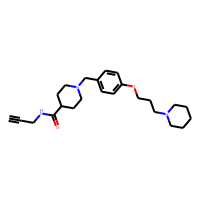

In [8]:
H3.head(1)

#### Calculate fingerprints

In [9]:
radius = 2
nBits = 1024

In [10]:
ECFP4 = [AllChem.GetMorganFingerprintAsBitVect(x, radius = radius, nBits = nBits) for x in H3['ROMol']]

In [11]:
ecfp4_names = [f'Bit_{i}' for i in range(nBits)]
ecfp4_bits = [list(l) for l in ECFP4]
H3_ecfp4 = pd.DataFrame(ecfp4_bits, index = H3.SMILES, columns = ecfp4_names)

In [12]:
H3_ecfp4.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
H3_pKi = H3[['SMILES', 'pKi']]
H3_pKi.set_index('SMILES', inplace = True)

In [14]:
H3_pKi.head(1)

,pKi
SMILES,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,7.96


In [15]:
H3_Xy = H3_pKi.merge(H3_ecfp4, on = 'SMILES')

In [16]:
H3_Xy.head(1)

,pKi,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,7.96,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(H3.loc[1558, 'ROMol'], radius=2, bitInfo=bi)
# show 10 of the set bits:
list(fp.GetOnBits())[:10]

[2, 13, 80, 93, 102, 197, 257, 310, 322, 550]

In [18]:
from ipywidgets import interact, fixed, IntSlider
def renderFpBit(mol, bitIdx, bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol, bid, bitInfo)))

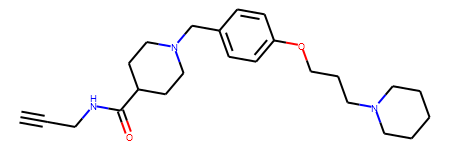

In [19]:
H3.loc[1558, 'ROMol']

In [20]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(H3.loc[1558, 'ROMol']),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(2, 13, 80, 93, 102, 197, 257, 310, 322, 550, 650…

#### Build training and test sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(H3_Xy.drop(['pKi'], axis = 1), H3_Xy['pKi'],
                                                   test_size = 0.2,
                                                   random_state = 42)

In [22]:
X_train.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [23]:
pd.DataFrame(y_train).head(3)

,pKi
SMILES,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,6.97
c1cc2cccnc2c(c1)c3cc4c(nc3)nc(o4)N5CCC(CC5)N6CCCCC6,7.46
COc1cccc(n1)c2cc3c(nc2)nc(o3)N4CCC(CC4)N5CCCCC5,7.64


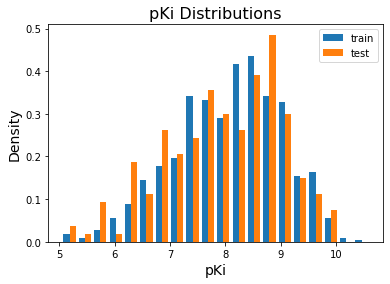

In [24]:
# create dataframe, select columns
df1x = pd.to_numeric(pd.DataFrame(y_train)['pKi'])
df2x = pd.to_numeric(pd.DataFrame(y_test)['pKi'])
#Stack the data
plt.figure()
plt.hist([df1x,df2x], bins = 20, stacked = False, density = True)
plt.title('pKi Distributions', fontsize = 16)
plt.xlabel('pKi', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(['train', 'test'])
plt.show()

#### k-Nearset Neighbors Regression

##### Create k-nearest neighbors regressor

In [25]:
knn = KNeighborsRegressor()

In [26]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(knn.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


###### ...define grid search

##### Train model ... grid search

In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

NameError: name 'RandomForestRegressor' is not defined

In [38]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [40]:
best_random = rf_random.best_estimator_

In [59]:
best_random.score(X_train, y_train)

0.9967480039312516

In [60]:
best_random.score(X_test, y_test)

0.657239052550656

##### Train model

In [28]:
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [29]:
knn.score(X_train, y_train)

0.6836543117330649

In [30]:
knn.score(X_test, y_test)

0.4841664281836291

In [31]:
predict_train = pd.DataFrame(knn.predict(X_train).flatten())
predict_train['set'] = 'train'
predict_test = pd.DataFrame(knn.predict(X_test).flatten())
predict_test['set'] = 'test'

pred = predict_train.append(predict_test)
pred.columns = ['pred', 'set']

expt_train = pd.DataFrame(y_train)
expt_train['set'] = 'train'
expt_test = pd.DataFrame(y_test)
expt_test['set'] = 'test'

expt = expt_train.append(expt_test)
expt.columns = ['expt', 'set']

In [32]:
pred.reset_index(inplace = True, drop = True)
expt.reset_index(inplace = True, drop = True)

Text(0, 0.5, 'Experimental pKi')

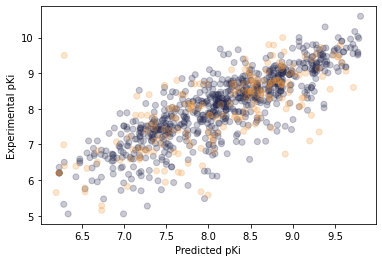

In [33]:
qaz = pd.concat([expt, pred['pred']], axis = 1)

qaz['color'] = np.where(qaz['set'] == 'train', '#26294d', '#f59b3f')

xPlot = qaz['pred']
yPlot = qaz['expt']
colors = qaz['color']

plt.scatter(xPlot, yPlot, c = colors, alpha = 0.25)
plt.xlabel("Predicted pKi")
plt.ylabel("Experimental pKi")

In [34]:
y_pred = knn.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
rmse

0.5429189866284533

In [35]:
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.7495519075929071

#### SHAP

In [36]:
import shap

In [37]:
# load JS visualization code to notebook
shap.initjs()

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.KernelExplainer(knn.predict, shap.sample(X_test, 50))
shap_values = explainer.shap_values(X_test)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

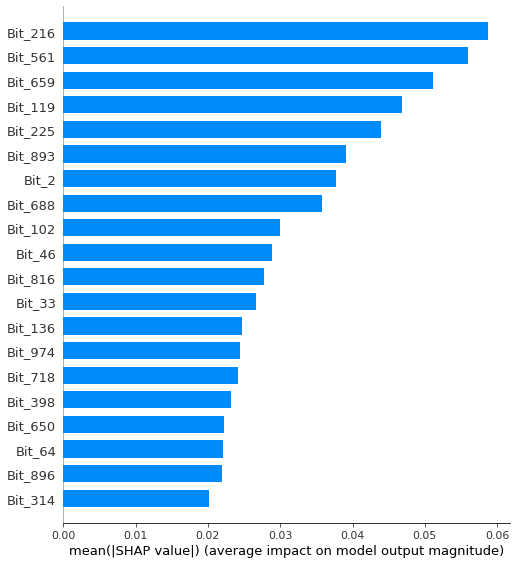

In [39]:
shap.summary_plot(shap_values, X_test, plot_type = 'bar')

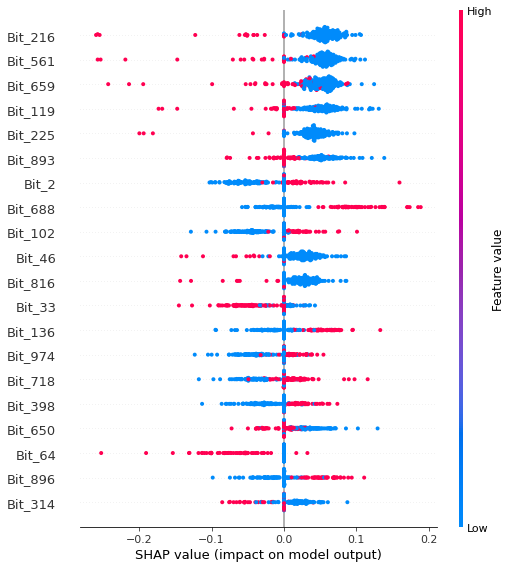

In [40]:
shap.summary_plot(shap_values, X_test)

In [42]:
# Get the predictions and put them in with the test data
X_output = X_test.copy()
X_output.loc[:, 'predict'] = np.round(knn.predict(X_output), 2)

# Randomly pick some observations
random_picks = np.arange(1, 200, 50)
qaz = X_output.iloc[random_picks]
qaz

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,predict
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1CCCN1CCc2ccc3c(c2)ccc(n3)c4cc(no4)C(=O)OC,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,8.95
CC1CC(CN(C1)Cc2ccc(cc2)c3ccc(cc3)CN4CC(CC(C4)C)C)C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,7.93
CC(C)NC(=O)N1CCc2ccc(cc2C1)OCCCN3CCCCC3,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.45
Cc1c(c(no1)c2ccccc2)c3ccc4cc(ccc4n3)CCN5CCCC5C,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,8.88


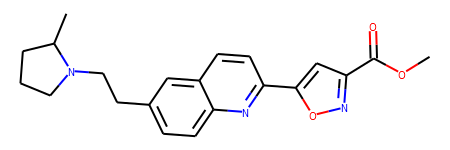

In [43]:
m = Chem.MolFromSmiles('CC1CCCN1CCc2ccc3c(c2)ccc(n3)c4cc(no4)C(=O)OC')
m

In [44]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius = 2, nBits = 1024, bitInfo = bi)
# show 10 of the set bits:
list(fp.GetOnBits())

[1,
 4,
 33,
 72,
 73,
 80,
 104,
 118,
 121,
 128,
 145,
 203,
 219,
 248,
 285,
 301,
 310,
 356,
 363,
 378,
 412,
 423,
 446,
 456,
 518,
 545,
 589,
 650,
 656,
 675,
 690,
 695,
 719,
 726,
 729,
 730,
 734,
 774,
 807,
 831,
 841,
 849,
 855,
 875,
 893,
 906,
 926,
 927,
 935,
 961,
 978,
 980,
 998,
 1015,
 1019]

In [45]:
def shap_plot(j):
#    explainerModel = shap.KernelExplainer(SVR_model, X)
    shap_values_Model = explainer.shap_values(qaz.drop(['predict'], axis = 1))
    p = shap.force_plot(explainer.expected_value, shap_values_Model[j], qaz.drop(['predict'], axis = 1).iloc[[j]])
    return(p)

In [46]:
shap_plot(0)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [47]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(m),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(1, 4, 33, 72, 73, 80, 104, 118, 121, 128, 145, 2…

#### SHAP workflow

In [51]:
import shap
import time

shap.initjs() # load JS visualization code to notebook

In [95]:
start_time = time.time()
start_time
explainer = shap.KernelExplainer(knn.predict, shap.sample(X_test, 10))
# explainer = shap.KernelExplainer(knn.predict, X_test)
end_time = time.time()
end_time
end_time-start_time

0.060839176177978516

In [91]:
X_test.shape

(193, 1024)

In [93]:
shap.sample(X_test, 5)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
c1cc(ccc1C2=NNC(=O)C3C2C3)OCCCN4CCCCC4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CC(C)N1CCN(CC1)C(=O)OC2CCN(CC2)c3ccn(c(=O)c3)C,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
c1cc(ncc1c2cc3c(nc2)nc(s3)N4CCC(CC4)N5CCCCC5)O,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
c1cc(cc2c1cc(o2)C(=O)N3CCCC3CN4CCCC4)C(F)(F)F,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
c1cc(ccc1OCCCCCCN2CCCCC2)Cl,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
start_time = time.time()
start_time
shap_values = explainer.shap_values(X_test)
end_time = time.time()
end_time
end_time-start_time

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

7357.210230112076

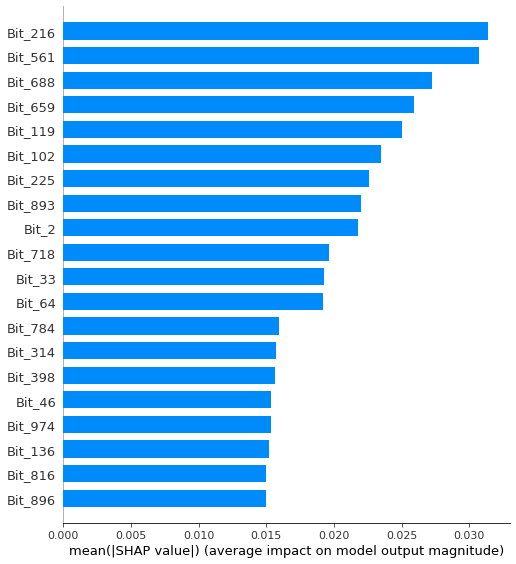

In [97]:
shap.summary_plot(shap_values, X_test, plot_type = 'bar')

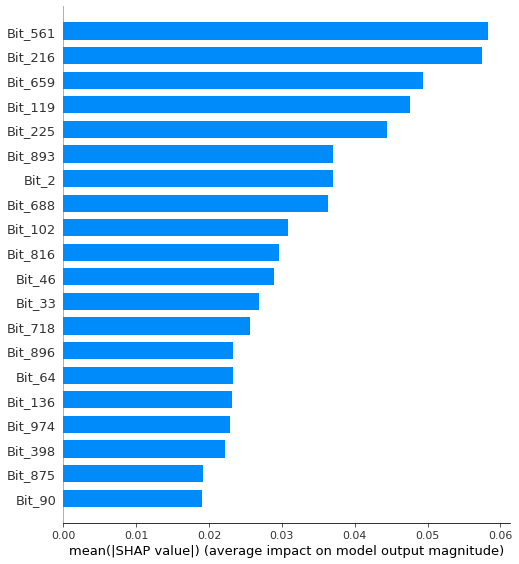

In [56]:
shap.summary_plot(shap_values, X_test, plot_type = 'bar')

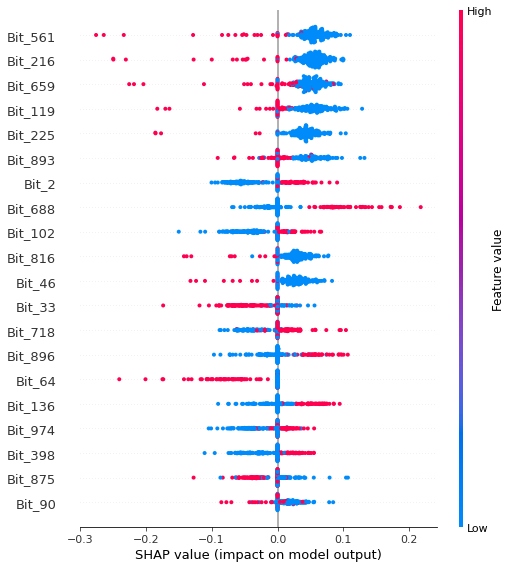

In [57]:
shap.summary_plot(shap_values, X_test)

In [58]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[[0]])

In [59]:
from ipywidgets import interact, fixed, IntSlider
def renderFpBit(mol, bitIdx, bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol, bid, bitInfo)))

In [78]:
X_test.head(10)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1CCCN1CCc2cc3cc(ccc3o2)CNc4ccc(cn4)[N+](=O)[O-],0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
CC1CCCN1CCc2ccc3c(c2)ccc(n3)c4cc(no4)C(=O)OC,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
CC1CCCN1CCc2cc3cc(ccc3o2)CNc4ncc(s4)[N+](=O)[O-],0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
c1cc(ccc1N2CCN(CC2=O)C(=O)c3cc(cc(c3)F)F)OCCCN4CCCCCC4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC1CCCN1CCCOc2ccc(cc2)C(=O)CN3CCN(CC3)C(=O)Oc4ccc(cc4)F,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
c1cc(ccc1C#N)C(=O)N2CCN(C(=O)C2)c3ccc(cc3)OCCCN4CCCCCC4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC(COc1ccc2c(c1)CCC3(O2)CCN(CC3)C4CCC4)O,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CCCN(CCC)Cc1ccc(cc1)c2ccc(cc2)CN3CCCCC3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC(C)N1CCC(CC1)Oc2ccc3c(c2)cc(n3CC(F)(F)F)C(=O)N4CCC(CC4)(F)F,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


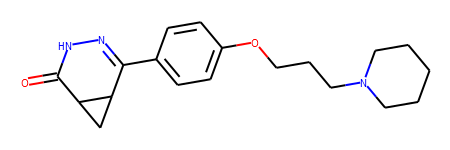

In [86]:
m = Chem.MolFromSmiles('c1cc(ccc1C2=NNC(=O)C3C2C3)OCCCN4CCCCC4')
m

In [87]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo=bi)

In [88]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(m),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(2, 13, 80, 102, 314, 322, 378, 417, 455, 516, 59…

In [89]:
list(fp.GetOnBits())

[2,
 13,
 80,
 102,
 314,
 322,
 378,
 417,
 455,
 516,
 592,
 650,
 653,
 695,
 718,
 887,
 896,
 903,
 917,
 926,
 935,
 988,
 1019,
 1028,
 1034,
 1114,
 1145,
 1160,
 1292,
 1380,
 1422,
 1444,
 1452,
 1480,
 1482,
 1615,
 1712,
 1750,
 1791,
 1798,
 1841,
 1873,
 1911,
 1998]

In [66]:
len(shap_values[1])

1024

In [83]:
for i in range(1024):
     print(i, shap_values[8][i])

0 0.0
1 0.0
2 -0.050267376792307805
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 -0.05605742755856913
34 0.0
35 0.0
36 0.010441729248368142
37 0.0
38 0.0
39 0.0
40 0.0
41 0.006534166628745508
42 0.0
43 0.0
44 0.0
45 0.03165143019704103
46 0.025944170048569415
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.009898548976240318
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 -0.03823838982990446
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.007799715609971558
115 0.0
116 0.0
117 0.0
118 0.0
119 0

In [73]:
range(1024)

range(0, 1024)

In [98]:
7357.21/3600

2.0436694444444443